**Predicting bike usage in Paris**
===
### Why?

Since the COVID-19 pandemic, the usage rate of bikes as a mode of commute in Paris has increased significantly. 
While the City of Paris has implemented many new bike lanes to make cycling around Paris safer and more ergonomic, there are times where the bike traffic on certain streets is congested.

Personally, as a bike-user in Paris, I have found navigating some streets where the traffic is very busy to be frustrating and slow, and make me feel unsafe. 

### What?

To help commuters decide which mode of transport to take (i.e. bike, walk, metro, bus, etc...) or even whether or not they should work in-office, or remotely, we aim to predict the traffic of bikes in Paris to give an indication of what a commuter's experience will be like on a given day at a given time. 

### How?

The City of Paris provides many different public APIs and datasets for anyone to use, including urban projects, environmental data, demographics, public services, and traffic information; specifically, among other things, the traffic of bikes counted per hour. 

Using past traffic datadata, along with external factors, such as past weather data and forecasts, we hypothesise that trends will be apparent, and that we will be able to forecast future traffic trends using a machine-learning algorithm. 

In [26]:
import pandas as pd
import numpy as np 
import plotly.express as px
import datetime
from pytz import timezone
import plotly


Import and read the csv "comptage-velo-donnees-compteurs.csv" from the Paris townhall. 
The csv is a database of the number of bicycles recorded that are detected by electronic counters placed on streets of Paris that are known to be or expected to be high-traffic streets for bicycles.

In [47]:
# df = pd.read_csv("comptage-velo-donnees-compteurs1.csv", sep=';')
df = pd.read_csv("comptage-velo-donnees-compteurs.csv", sep=';')

In [48]:
df.head(1)

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,Lien vers photo du site de comptage,Coordonnées géographiques,Identifiant technique compteur,ID Photos,test_lien_vers_photos_du_site_de_comptage_,id_photo_1,url_sites,type_dimage,mois_annee_comptage
0,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,3.0,2021-10-01T03:00:00+02:00,2012-02-22,https://filer.eco-counter-tools.com/file/b8/c9...,"48.83504,2.33314",X2H20012081,https://filer.eco-counter-tools.com/file/b8/c9...,https://filer.eco-counter-tools.com/file/b8/c9...,https:,https://www.eco-visio.net/Photos/100003096,jpg,2021-10


In [ ]:
df1.head(-1)

As this database includes a lot of data that aren't necessary for the purposes of predicting how many bikes will be present on the streets of Paris, we will reduce the database to the columns that are of interest: The name of the counter, the count, the date and time, and the geographical coordinates.

In [51]:
df = df.loc[:, ["Nom du compteur", "Comptage horaire", "Date et heure de comptage", "Coordonnées géographiques"]]

In [52]:
df.head(1)

,Nom du compteur,Comptage horaire,Date et heure de comptage,Coordonnées géographiques
0,97 avenue Denfert Rochereau SO-NE,3.0,2021-10-01T03:00:00+02:00,"48.83504,2.33314"


The column "Date et heure de comptage" is a series of strings.  So that we can use this in a machine learning algorithm, it is necessary to change these to timestamps using `pandas.to_datetime`. 

In [53]:
df["DateTime"] = pd.to_datetime(df["Date et heure de comptage"], utc=True)

In order to visualise this data, the date needs to be sorted in order of date and time. 

In [54]:
df.sort_values(by='DateTime', inplace=True)
print("The first data point was taken on:", df.DateTime.tolist()[0])
print("The last data point was taken on:", df.DateTime.tolist()[-1])

The first data point was taken on: 2021-10-01 01:00:00+00:00
The last data point was taken on: 2022-11-05 22:00:00+00:00


In [56]:
df.head(1)

,Nom du compteur,Comptage horaire,Date et heure de comptage,Coordonnées géographiques,DateTime
0,97 avenue Denfert Rochereau SO-NE,3.0,2021-10-01T03:00:00+02:00,"48.83504,2.33314",2021-10-01 01:00:00+00:00


Now that the data are sorted and timestamped, it is interesting to know how many counters are used, and to visualise where these counters are on a map.  

In [57]:
print("The number of counters in paris is: ", len(df["Nom du compteur"].unique().tolist()))

The number of counters in paris is:  99


In [58]:
compteurs = df.loc[:, ["Nom du compteur", "Coordonnées géographiques"]]
compteurs.drop_duplicates(subset="Nom du compteur").to_csv('compteurs.csv', index=False)

<a href="https://www.google.com/maps/d/u/0/edit?mid=1OkFpqexCCqSCl63CaGrGgVTCRIp5n6Q&usp=sharing">Carte des compteurs vélo à Paris</a>


There are 99 unique counters in the database, and their locations are displayed below:

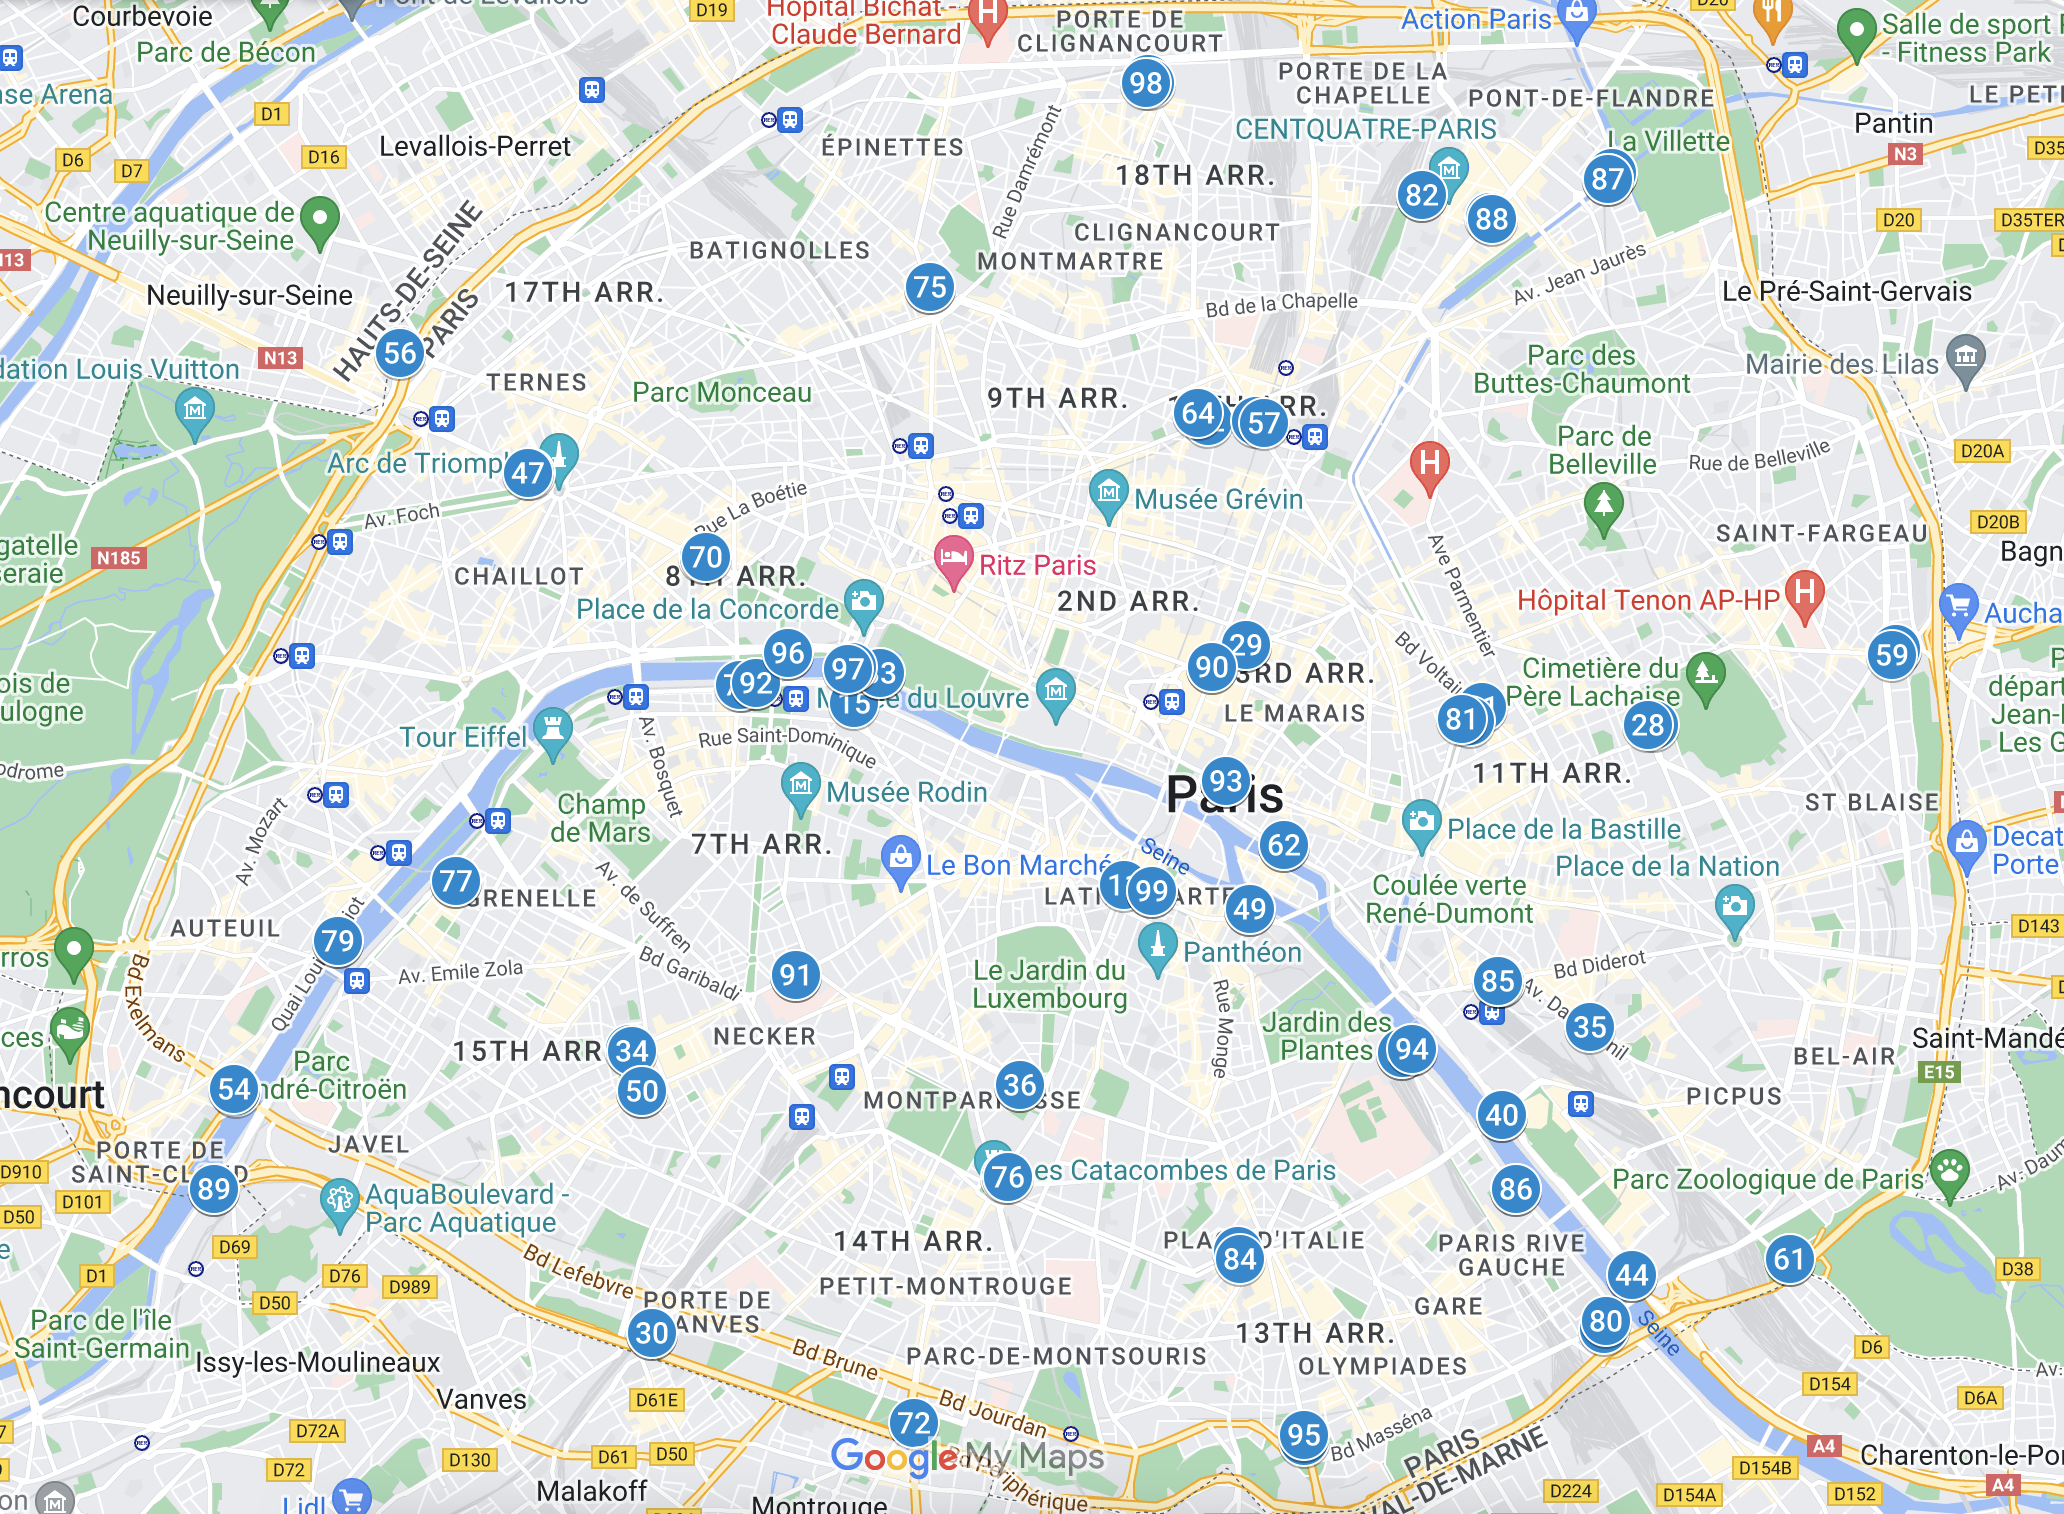

The data can be visualised on a line graph.  There are clearly some outliers that were likely caused by a bug or error in data collection. 

In [ ]:
fig = px.line(df, x="DateTime", y="Comptage horaire", color="Nom du compteur")
fig.show()

Let's investigate those outliers... 

In [ ]:
outliers = df[df["Comptage horaire"] > 2000.0]
outliers

There are only three significant outliers, and they are all on the same day in early August.  These data were probably caused by roadworks, which are common in Paris in summer, when many parisiens leave Paris for vacation.  

To exclude these data from our predictions, they must be replaced by more reasonable values.  What should these values be replaced with? 

In [61]:
df[df["Comptage horaire"] < 2000.0]["Comptage horaire"].describe()

count    895016.000000
mean         69.617991
std          94.515364
min           0.000000
25%           8.000000
50%          37.000000
75%          92.000000
max        1327.000000
Name: Comptage horaire, dtype: float64

Given that the values seem to be very dependant on the day of the week and time of day, it's coherent to replace these values with other values on the same day and time.  Therefore, it is valuable to extract the day of the week and time of day for each line of our database...

In [62]:
df["Heure"] = list(map(lambda n: n.strftime("%H:%M"), df["DateTime"]))
df["Jour de semaine"] = list(map(lambda n: n.weekday(), df["DateTime"]))
df.head(1)

,Nom du compteur,Comptage horaire,Date et heure de comptage,Coordonnées géographiques,DateTime,Heure,Jour de semaine
0,97 avenue Denfert Rochereau SO-NE,3.0,2021-10-01T03:00:00+02:00,"48.83504,2.33314",2021-10-01 01:00:00+00:00,01:00,4


Upon inspection, we can recognise that the outliers were recorded on a monday at 1am, 11am and midday. 

In [ ]:
outliers = df[df["Comptage horaire"] > 2000.0]
outliers

As the average values on these days at these times are affected by the outliers, a reasonable option is to use the median value on these days at these times to replace the outlier values

In [64]:
df.head(1)

,Nom du compteur,Comptage horaire,Date et heure de comptage,Coordonnées géographiques,DateTime,Heure,Jour de semaine
0,97 avenue Denfert Rochereau SO-NE,3.0,2021-10-01T03:00:00+02:00,"48.83504,2.33314",2021-10-01 01:00:00+00:00,01:00,4


In [65]:
print(df.loc[(df["Nom du compteur"] == "39 quai François Mauriac SE-NO") & (df["Jour de semaine"] == 6) & (df["Heure"] == "23:00")]["Comptage horaire"].describe())
print(df.loc[(df["Nom du compteur"] == "39 quai François Mauriac SE-NO") & (df["Jour de semaine"] == 0) & (df["Heure"] == "09:00")]["Comptage horaire"].describe())
print(df.loc[(df["Nom du compteur"] == "39 quai François Mauriac SE-NO") & (df["Jour de semaine"] == 0) & (df["Heure"] == "10:00")]["Comptage horaire"].describe())


count      52.000000
mean       96.615385
std       663.767416
min         0.000000
25%         2.000000
50%         4.500000
75%         7.000000
max      4791.000000
Name: Comptage horaire, dtype: float64
count      52.000000
mean      102.461538
std       328.890497
min         0.000000
25%        49.750000
50%        61.500000
75%        73.250000
max      2423.000000
Name: Comptage horaire, dtype: float64
count      52.000000
mean      213.538462
std      1070.383319
min         0.000000
25%        50.500000
50%        64.500000
75%        89.000000
max      7781.000000
Name: Comptage horaire, dtype: float64


In [ ]:
df.at[outliers.index.values.tolist(), "Comptage horaire"] = [4.0, 61.0, 64.0]

In [ ]:
df[df["Comptage horaire"] > 2000.0]

Now that there are no more outliers, it is easier to visualise and recognise trends in our database

In [ ]:
fig = px.line(df, x="DateTime", y="Comptage horaire", color="Nom du compteur")
fig.show()

In [ ]:
df.head(1)

Our data is now ready to be prepared for modelisation

In [ ]:
df = df.loc[:, ["Nom du compteur", "Comptage horaire", "DateTime", "Heure", "Jour de semaine"]]
df.head(1)

In order to make predictions based on each counter, the data need to be formatted based on DateTime against the counter name

In [ ]:
df.DateTime = df.DateTime.values
valeurs_par_dateheure = df.pivot(index='DateTime', columns='Nom du compteur')['Comptage horaire']
valeurs_par_dateheure.head()

In [ ]:
valeurs_par_dateheure["Heure"] = list(map(lambda n: n.strftime("%H:%M"), valeurs_par_dateheure.index))
valeurs_par_dateheure["Jour de semaine"] = list(map(lambda n: n.weekday(), valeurs_par_dateheure.index))
valeurs_par_dateheure.head(1)

In [73]:
valeurs_par_dateheure["valeur time"] = valeurs_par_dateheure.index
valeurs_par_dateheure.index = valeurs_par_dateheure.index.to_period("H")

In [ ]:
valeurs_par_dateheure.head(1)

At this point, we can recognise a problem -- There are `NaN` values.  Perhaps this was caused by failures or roadworks. In any case, these must be removed to prevent errors in modelisation. 

To find out which counters are impacted, we can check which counters have `NaN` values, and how many of these values they have. 

There are 33 counters impacted, but some are only slightly impacted, whereas others are significantly impacted. 

In [75]:
null_values = pd.DataFrame(valeurs_par_dateheure.isna().sum()).rename(columns={0: "not number"})
print("Number of counters with null values: ", len(null_values.loc[null_values["not number"] > 0]))
print(null_values.loc[null_values["not number"] > 0])

Number of counters with null values:  32
                                       not number
Nom du compteur                                  
100 rue La Fayette O-E                       3240
105 rue La Fayette E-O                       3037
129 rue Lecourbe SO-NE                         13
152 boulevard du Montparnasse E-O             487
152 boulevard du Montparnasse O-E             487
16 avenue de la Porte des Ternes E-O          324
18 quai de l'Hôtel de Ville NO-SE              12
2 avenue de la Porte de Bagnolet O-E           15
20 Avenue de Clichy NO-SE                    6167
20 Avenue de Clichy SE-NO                    6167
21 boulevard Saint Michel S-N                4944
254 rue de Vaugirard NE-SO                    977
254 rue de Vaugirard SO-NE                    977
28 boulevard Diderot E-O                     3998
28 boulevard Diderot O-E                     3998
30 rue Saint Jacques (temporaire) N-S        8183
30 rue Saint Jacques N-S                     1451
39 quai F

There are many ways that we can resolve this problem.  For simplicity's sake, we can consider that we can replace `NaN` values for counters for which less than 1% of their values are impacted by system errors or roadworks.  The counters whose values are impacted more than 1% can be removed. 

In [76]:
print("Number of counters with more than 1% null values: ", len(null_values.loc[null_values["not number"] > int(len(valeurs_par_dateheure.index)/100)]))
null_values.loc[null_values["not number"] > int(len(valeurs_par_dateheure.index)/100)]


Number of counters with more than 1% null values:  24


,not number
Nom du compteur,
100 rue La Fayette O-E,3240
105 rue La Fayette E-O,3037
152 boulevard du Montparnasse E-O,487
152 boulevard du Montparnasse O-E,487
16 avenue de la Porte des Ternes E-O,324
20 Avenue de Clichy NO-SE,6167
20 Avenue de Clichy SE-NO,6167
21 boulevard Saint Michel S-N,4944
254 rue de Vaugirard NE-SO,977


Here is a list of all of the counters that will be removed. 

In [ ]:
counters_to_remove  = null_values.loc[null_values["not number"] > int(len(valeurs_par_dateheure.index)/100)].index.values.tolist()
counters_to_remove

In [78]:
valeurs_par_dateheure = valeurs_par_dateheure.drop(columns=counters_to_remove)

In [ ]:
valeurs_par_dateheure

In [80]:
updated_null_values = pd.DataFrame(valeurs_par_dateheure.isna().sum()).rename(columns={0: "not number"})
print("Number of counters with null values: ", len(updated_null_values.loc[updated_null_values["not number"] > 0]))
print(updated_null_values.loc[updated_null_values["not number"] > 0])


Number of counters with null values:  8
                                      not number
Nom du compteur                                 
129 rue Lecourbe SO-NE                        13
18 quai de l'Hôtel de Ville NO-SE             12
2 avenue de la Porte de Bagnolet O-E          15
Face au 48 quai de la marne NE-SO             11
Face au 48 quai de la marne SO-NE             11
Totem 64 Rue de Rivoli E-O                    28
Totem 64 Rue de Rivoli O-E                    28
Totem 73 boulevard de Sébastopol S-N           3


For the remaining 9 counters that have `NaN` values, less than 0.5% of their values are impacted. We can replace those values with `0`, as this will likely have a minimal impact on the modelisation. 

In [ ]:
valeurs_par_dateheure.loc[valeurs_par_dateheure["Totem 73 boulevard de Sébastopol S-N"].isna()]

In [82]:
valeurs_par_dateheure = valeurs_par_dateheure.fillna(0)

In [ ]:
valeurs_par_dateheure.head()

Now we can proceed to Modelisation. 

**Modelisation**
=======

Our database is broken down by date and hour, as there are 24 hours in a day, we can detemine how many days of data we have.

In [84]:
len(valeurs_par_dateheure.index)/24

400.8333333333333

As there is roughly 13 months of data, we can split define our test split to be 30 days * 24 hours = 720. 

In [85]:
from sktime.forecasting.model_selection import temporal_train_test_split

df_train, df_test = temporal_train_test_split(valeurs_par_dateheure, test_size=720)

In [86]:
counter = 'Totem 73 boulevard de Sébastopol S-N'
import sktime
from sktime.forecasting.naive import NaiveForecaster

naive_model = NaiveForecaster(sp=8755)
 
naive_model.fit(df_train[counter])

naive_preds = naive_model.predict(fh=list(range(1,721)))

In [ ]:
data = valeurs_par_dateheure.loc[:, ["valeur time", counter]]
data['modèle naïf'] = np.nan

data.iloc[-720:, -1] = naive_preds

px.line(data, x="valeur time", y=[counter, 'modèle naïf'])


In [88]:
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error

naive_MAE = mean_absolute_error(y_true = df_test[counter], 
                          y_pred = naive_preds)

print(naive_MAE)

239.0875


**Silverkite**
====

In [89]:
from greykite.framework.templates.autogen.forecast_config import ForecastConfig, MetadataParam, ModelComponentsParam

forecast_config = ForecastConfig(
    model_template = "SILVERKITE",
    forecast_horizon = 672,
    coverage = 0.95,
    metadata_param = MetadataParam(
      time_col = "valeur time",
      value_col = "Totem 73 boulevard de Sébastopol S-N",
      freq = "H",
      train_end_date=datetime.datetime(2022, 10, 12)
   )
)

In [ ]:
from greykite.framework.templates.forecaster import Forecaster

forecaster = Forecaster()

silverkite = forecaster.run_forecast_config(
    df = valeurs_par_dateheure,
    config = forecast_config
)

In [ ]:
print(silverkite.forecast.test_evaluation['MAE'])
silverkite.forecast.plot()

**Impact of public holidays**
====

In [ ]:
custom_silverkite = ModelComponentsParam(
    events = {
         "holiday_lookup_countries": ["France"],
         "holiday_pre_num_days": 0,
         "holiday_post_num_days": 0,
         "holidays_to_model_separately":  ["Jour de l'an",
                                          "Fête du Travail",
                                          "Armistice 1945",
                                          "Fête nationale",
                                          "Armistice 1918",
                                          "Lundi de Pâques",
                                          "Lundi de Pentecôte",
                                          "Ascension",
                                          "Assomption",
                                          "Toussaint",
                                          "Noël"
                                         ]
     }
)
forecast_config = ForecastConfig(
    model_template = "SILVERKITE",
    forecast_horizon = 672,
    coverage = 0.95,
    model_components_param = custom_silverkite,
    metadata_param = MetadataParam(
      time_col = "valeur time",
      value_col = "Totem 73 boulevard de Sébastopol S-N",
      freq = "H",
      train_end_date=datetime.datetime(2022, 10, 12)
   )
)
forecaster = Forecaster()
silverkite = forecaster.run_forecast_config(
    df = valeurs_par_dateheure,
    config = forecast_config
)


In [ ]:
print(silverkite.forecast.test_evaluation['MAE'])
silverkite.forecast.plot()

**Impact of rain**
====

In [ ]:
meteo = pd.read_csv("donnees-synop-essentielles-omm.csv", sep=";")
meteo = meteo.loc[:, ["Date", "Précipitations dans la dernière heure"]]
meteo.sort_values(by='Date', inplace=True)
meteo2 = pd.read_csv("donnees-synop-essentielles-omm (2).csv", sep=";")
meteo2 = meteo2.loc[:, ["Date", "Précipitations dans la dernière heure"]]
meteo2.sort_values(by='Date', inplace=True)
meteo = meteo.append(meteo2)
meteo

In [95]:
meteo["Précipitations dans la dernière heure"].describe()

count    3211.000000
mean        0.066272
std         0.552969
min        -0.100000
25%         0.000000
50%         0.000000
75%         0.000000
max        16.100000
Name: Précipitations dans la dernière heure, dtype: float64

In [96]:
meteo["Date"] = pd.to_datetime(meteo["Date"])
meteo["Date"] = list(map(lambda x: datetime.datetime.strftime(x,"%Y-%m-%d %H:%M"), meteo["Date"]))
meteo.sort_values(by='Date', inplace=True)
meteo = meteo.groupby("Date").sum()
meteo.index = pd.to_datetime(meteo.index)
meteo = meteo.resample("H").ffill()
meteo

,Précipitations dans la dernière heure
Date,
2021-10-01 02:00:00,0.0
2021-10-01 03:00:00,0.0
2021-10-01 04:00:00,0.0
2021-10-01 05:00:00,0.0
2021-10-01 06:00:00,0.0
...,...
2022-11-05 15:00:00,0.0
2022-11-05 16:00:00,0.0
2022-11-05 17:00:00,0.0


In [97]:
meteo = meteo.rename(columns={"Précipitations dans la dernière heure":"rain"})

In [98]:
meteo.index = meteo.index.to_period("H")

In [ ]:
valeurs_par_dateheure = pd.merge(valeurs_par_dateheure, meteo, left_index=True, right_index=True)
valeurs_par_dateheure["valeur time"] = valeurs_par_dateheure.index.to_timestamp()
valeurs_par_dateheure

**Forecast with rain**

In [ ]:
previsions = pd.read_csv("arome-0025-sp1_sp2_paris (1).csv", sep=";")
previsions = previsions.loc[:, ["Forecast timestamp", "Total precipitation"]]
previsions["Forecast timestamp"] = pd.to_datetime(previsions["Forecast timestamp"], utc=True)
previsions = previsions.sort_values(by="Forecast timestamp")
previsions = previsions.groupby("Forecast timestamp").mean().fillna(0.0)
previsions.index = pd.to_datetime(previsions.index)
previsions.index = previsions.index.to_period("H")
previsions = previsions.rename(columns={"Total precipitation":"rain"})
previsions

In [101]:
valeurs_par_dateheure = valeurs_par_dateheure.append(previsions.tail(23))


/var/folders/53/mdfj3z_j66l_fj3lg1nmkg2m0000gn/T/ipykernel_99599/1972184119.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
valeurs_par_dateheure["valeur time"] = valeurs_par_dateheure.index.to_timestamp()
valeurs_par_dateheure

In [ ]:
subset_df = valeurs_par_dateheure.loc[:, ["valeur time", "Totem 73 boulevard de Sébastopol S-N", "rain"]]
subset_df

In [ ]:
custom_silverkite = ModelComponentsParam(
    regressors = {
        "regressor_cols": ["rain"]
    }
)
forecast_config = ForecastConfig(
    model_template = "SILVERKITE",
    forecast_horizon = 672,
    coverage = 0.95,
    model_components_param = custom_silverkite,
    metadata_param = MetadataParam(
        time_col = "valeur time",
        value_col = "Totem 73 boulevard de Sébastopol S-N",
        freq = "H",
        train_end_date=datetime.datetime(2022, 10, 12)
    )
)
forecaster = Forecaster()
silverkite = forecaster.run_forecast_config(
    df = subset_df,
    config = forecast_config
)

In [105]:
ts = silverkite.timeseries
print(ts.regressor_cols)   

['rain']


In [ ]:
print(silverkite.forecast.test_evaluation['MAE'])
silverkite.forecast.plot()

In [107]:
silverkite.forecast.test_evaluation['MAE']

66.82565214705345

In [ ]:
custom_silverkite = ModelComponentsParam(
    regressors = {
        "regressor_cols": ["rain"]
    },
    events = {
         "holiday_lookup_countries": ["France"],
         "holiday_pre_num_days": 0,
         "holiday_post_num_days": 0,
         "holidays_to_model_separately":  ["Jour de l'an",
                                          "Fête du Travail",
                                          "Armistice 1945",
                                          "Fête nationale",
                                          "Armistice 1918",
                                          "Lundi de Pâques",
                                          "Lundi de Pentecôte",
                                          "Ascension",
                                          "Assomption",
                                          "Toussaint",
                                          "Noël"
                                         ]
     }
)
forecast_config = ForecastConfig(
    model_template = "SILVERKITE",
    forecast_horizon = 672,
    coverage = 0.95,
    model_components_param = custom_silverkite,
    metadata_param = MetadataParam(
      time_col = "valeur time",
      value_col = "Totem 73 boulevard de Sébastopol S-N",
      freq = "H",
      train_end_date=datetime.datetime(2022, 10, 12)
   )
)
forecaster = Forecaster()
silverkite = forecaster.run_forecast_config(
    df = subset_df,
    config = forecast_config
)


In [ ]:
print(silverkite.forecast.test_evaluation['MAE'])
silverkite.forecast.plot()

There are two significant trends in late December and in August.  These times correspond with periods when a majority of Parisiens leave paris for vacation.
The model can be tuned to take into account these periods, which have an impact on the values

In [110]:
valeurs_par_dateheure["vacances"] = False

In [111]:
valeurs_par_dateheure.index[0]

Period('2021-10-01 02:00', 'H')

In [112]:
pd.Timestamp(year=2021, month=12, day=22, hour=0).to_period("H")

Period('2021-12-22 00:00', 'H')

In [113]:
valeurs_par_dateheure.loc[(valeurs_par_dateheure.index > pd.Timestamp(year=2021, month=12, day=22, hour=0).to_period("H")) & (valeurs_par_dateheure.index < pd.Timestamp(year=2022, month=1, day=3, hour=0).to_period("H")), "vacances"] = True
valeurs_par_dateheure.loc[(valeurs_par_dateheure.index > pd.Timestamp(year=2022, month=8, day=1, hour=0).to_period("H")) & (valeurs_par_dateheure.index < pd.Timestamp(year=2022, month=8, day=31, hour=0).to_period("H")), "vacances"] = True
valeurs_par_dateheure.vacances.sum()



1006

In [114]:
valeurs_par_dateheure['vacances'] = valeurs_par_dateheure['vacances'].replace(False, 0)

In [115]:
valeurs_par_dateheure['vacances'] = valeurs_par_dateheure['vacances'].replace(True, 1)

In [ ]:
subset_df = valeurs_par_dateheure.loc[:, ["valeur time", "Totem 73 boulevard de Sébastopol S-N", "rain", "vacances"]]
subset_df

In [ ]:
custom_silverkite = ModelComponentsParam(
    seasonality = dict(
    weekly_seasonality=True,
    daily_seasonality=True,
),
    regressors = {
        "regressor_cols": ["rain", "vacances"]
    },
    events = {
         "holiday_lookup_countries": ["France"],
         "holiday_pre_num_days": 0,
         "holiday_post_num_days": 0,
         "holidays_to_model_separately":  ["Jour de l'an",
                                          "Fête du Travail",
                                          "Armistice 1945",
                                          "Fête nationale",
                                          "Armistice 1918",
                                          "Lundi de Pâques",
                                          "Lundi de Pentecôte",
                                          "Ascension",
                                          "Assomption",
                                          "Toussaint",
                                          "Noël"
                                         ]
     }
)
forecast_config = ForecastConfig(
    model_template = "SILVERKITE",
    forecast_horizon = 672,
    coverage = 0.95,
    model_components_param = custom_silverkite,
    metadata_param = MetadataParam(
      time_col = "valeur time",
      value_col = "Totem 73 boulevard de Sébastopol S-N",
      freq = "H",
      train_end_date=datetime.datetime(2022, 10, 12)
   )
)
forecaster = Forecaster()
silverkite = forecaster.run_forecast_config(
    df = subset_df,
    config = forecast_config
)


In [ ]:
print(silverkite.forecast.test_evaluation['MAE'])
silverkite.forecast.plot()

**Conclusion**
===

While the algorithm can more or less accurately predict the peaks of bike traffic in Paris, it would benefit from more data to be able to analyse the seasonality year-to-year. 

There are other external factors that likely impact bike traffic in Paris.  If we use these factors to tune our algorithm further, this may improve accuracy. 

To further tune the algorithm, we could consider: 
1. Temperature forecasts -- Cyclists may decide to work remotely or take public transport when the weather is very cold or very hot
2. Planned public transport closures and strikes -- Parisiens may be obliged to commute by bike when metro lines are closed for works
3. The price of petrol? 
